# **Projeto ion_productivity_forecast**

In [39]:
import pandas as pd
import numpy as np

# Math
from scipy import stats
from scipy.stats import norm
from math import exp
from math import sqrt

# Sazonalidade
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.seasonal import STL

# Date
from datetime import date

import itertools

import warnings
warnings.filterwarnings('ignore')

# Images
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.plotting import autocorrelation_plot
import plotly.graph_objects as go

# Split
from sklearn.model_selection import train_test_split 

# Models
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xg

# LSTM e ANN
# import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM


# from keras.models import Sequential
# from keras.layers import Dense

# PREPROCESSING AND METRICS
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

#import shap

# Pycaret
#import jinja2
#from pycaret.regression import *


# Prophet
#import prophet

#Save model
import pickle
from sklearn import externals

## **Dataset**

In [3]:
# Para aparecer todas as linhas e colunas do dataset

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
dataframe = pd.read_csv('/content/drive/MyDrive/Projetos_ion/ion_productivity_forecast/datas/vendas_forecast.csv', sep=';')
dataframe.head()

,numpedido,numcarga,numnota,condvenda,posicao,dtemissao,vltotal,vltabela,codcli,codvendedor,codfilial,codfilialnf,codplpag,codcob,origem,motorista,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,pedido_id,chave_nfe,perc_comissao,numpedidotv1,dtemissaonf,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho
0,8802020,227905.0,4589672.0,1,F,2021-09-27 00:00:00,505.730,505.7300,22580,1160,0,0,102,3,F,GEOVANE MATEUS DE ABREU SILVA,NaN,NaN,38.585,129,407a588a-1065-45b2-82e6-ca50afd4262c,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8802025,227909.0,4589715.0,1,F,2021-09-27 00:00:00,258.900,258.9000,28802,1160,0,0,102,3,F,NaN,NaN,NaN,6.090,30,a32960a0-3190-4f8d-9c3a-8e900f229380,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8802111,NaN,NaN,1,R,2021-09-27 00:00:00,673.187,673.1874,22580,2220,0,0,102,3,F,NaN,NaN,NaN,33.900,27,199eb056-c41e-46bc-b68c-c3d42bd488b4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8802436,227907.0,4589694.0,1,F,2021-09-27 00:00:00,229.920,229.9200,3020,1160,0,0,7,3,F,NaN,NaN,NaN,0.240,48,8852ee59-d81b-44f2-8699-fc2b9f2140e8,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8802438,228162.0,4594076.0,1,F,2021-09-27 00:00:00,555.840,555.8400,17814,1160,0,0,7,3,F,NaN,NaN,NaN,0.120,96,e35e899c-87f8-4fdb-a53c-426b2b6f654a,NaN,NaN,NaN,2021-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dataframe.shape

(9110, 40)

In [6]:
dataframe['dtemissao'] = pd.to_datetime(dataframe['dtemissao'])

In [7]:
dataframe = dataframe.sort_values(by=['dtemissao'])

In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9110 entries, 0 to 9109
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   numpedido                 9110 non-null   int64         
 1   numcarga                  8465 non-null   float64       
 2   numnota                   8550 non-null   float64       
 3   condvenda                 9110 non-null   int64         
 4   posicao                   9110 non-null   object        
 5   dtemissao                 9110 non-null   datetime64[ns]
 6   vltotal                   9110 non-null   float64       
 7   vltabela                  9110 non-null   float64       
 8   codcli                    9110 non-null   int64         
 9   codvendedor               9110 non-null   int64         
 10  codfilial                 9110 non-null   int64         
 11  codfilialnf               9110 non-null   int64         
 12  codplpag            

In [9]:
dataframe.describe()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codvendedor,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho
count,9.110000e+03,8465.000000,8.550000e+03,9110.0,9110.000000,9110.000000,9110.000000,9110.000000,9110.0,9110.0,9110.000000,9110.0,0.0,0.0,9110.000000,9110.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,9.225599e+06,237937.496397,4.772258e+06,1.0,2893.976497,2905.616872,15877.200329,1643.720307,0.0,0.0,52.108562,3.0,NaN,NaN,161.756613,263.976619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.333481e+05,6038.862434,9.932986e+04,0.0,7996.417473,8059.193483,11429.174005,2165.399131,0.0,0.0,73.431213,0.0,NaN,NaN,779.684113,578.655821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,8.802020e+06,84826.000000,4.588585e+06,1.0,0.000000,0.000000,405.000000,50.000000,0.0,0.0,2.000000,3.0,NaN,NaN,0.024000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,9.017757e+06,233114.000000,4.686229e+06,1.0,392.780000,393.712500,4855.000000,1160.000000,0.0,0.0,7.000000,3.0,NaN,NaN,15.300000,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,9.254040e+06,238549.000000,4.783392e+06,1.0,1150.800000,1154.420000,17814.000000,1839.000000,0.0,0.0,7.000000,3.0,NaN,NaN,50.504000,94.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9.430532e+06,242751.000000,4.858753e+06,1.0,2664.944250,2682.460000,22580.000000,2220.000000,0.0,0.0,102.000000,3.0,NaN,NaN,143.737500,285.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,9.612466e+06,247249.000000,4.934285e+06,1.0,273120.000000,273120.000000,39996.000000,100000.000000,0.0,0.0,330.000000,3.0,NaN,NaN,59973.800000,19204.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
dataframe.index = pd.Index(range(9110))
dataframe.head()

,numpedido,numcarga,numnota,condvenda,posicao,dtemissao,vltotal,vltabela,codcli,codvendedor,codfilial,codfilialnf,codplpag,codcob,origem,motorista,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,pedido_id,chave_nfe,perc_comissao,numpedidotv1,dtemissaonf,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho
0,8802020,227905.0,4589672.0,1,F,2021-09-27,505.73,505.73,22580,1160,0,0,102,3,F,GEOVANE MATEUS DE ABREU SILVA,NaN,NaN,38.585,129,407a588a-1065-45b2-82e6-ca50afd4262c,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8804585,227909.0,4589720.0,1,F,2021-09-27,2581.90,2581.90,28802,574,0,0,102,3,F,NaN,NaN,NaN,254.362,638,32eba715-6b04-45d2-9f9c-03f6ca3b3cad,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8804371,227909.0,4589721.0,1,F,2021-09-27,112.52,112.52,28802,574,0,0,102,3,F,NaN,NaN,NaN,8.960,28,f97931fe-e89f-4da6-9038-81a7ca47b650,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8804370,227905.0,4589673.0,1,F,2021-09-27,75.90,75.90,22580,574,0,0,102,3,F,GEOVANE MATEUS DE ABREU SILVA,NaN,NaN,9.330,10,0c6965a9-2f68-4b85-bcba-600a4a962036,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8804338,227905.0,4589671.0,1,F,2021-09-27,1787.90,1787.90,22580,574,0,0,102,3,F,GEOVANE MATEUS DE ABREU SILVA,NaN,NaN,157.281,424,1a7c8925-8146-4405-ba03-b5c6dc58d19e,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
dataframe.codvendedor = dataframe.codvendedor.values.astype(str)

Text(0, 0.5, 'Vendas')

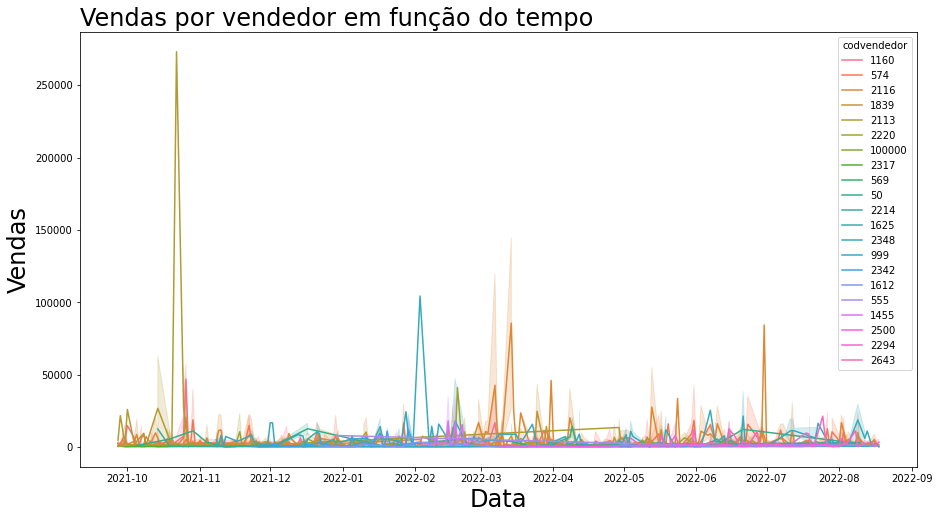

In [12]:
plt.figure(figsize=(15,8))
fig = sns.lineplot(x='dtemissao',y='vltotal',hue='codvendedor',data=dataframe)
fig.set_title('Vendas por vendedor em função do tempo', loc='left',fontsize=24)
fig.set_xlabel('Data',fontsize=24)
fig.set_ylabel('Vendas',fontsize=24)

In [13]:
#PEGANDO 1 VENDEDOR

dataframe['codvendedor'].value_counts()

1160      2321
2348      1674
574       1614
2116      1152
1839      1026
2294       391
2220       308
2113       254
1455       160
2342       100
50          35
1612        21
999         18
2500        11
555          7
2214         5
2643         5
100000       4
2317         2
1625         1
569          1
Name: codvendedor, dtype: int64

In [ ]:
df_1160 = dataframe[dataframe['codvendedor'] == '1160']
df_1160.head()

,numpedido,numcarga,numnota,condvenda,posicao,dtemissao,vltotal,vltabela,codcli,codvendedor,codfilial,codfilialnf,codplpag,codcob,origem,motorista,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,pedido_id,chave_nfe,perc_comissao,numpedidotv1,dtemissaonf,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho
0,8802020,227905.0,4589672.0,1,F,2021-09-27,505.73,505.73,22580,1160,0,0,102,3,F,GEOVANE MATEUS DE ABREU SILVA,NaN,NaN,38.585,129,407a588a-1065-45b2-82e6-ca50afd4262c,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,8802650,227867.0,4588796.0,1,ET,2021-09-27,594.24,594.24,11790,1160,0,0,7,3,F,IVANILDO DEODATO DA SILVA,NaN,NaN,0.576,96,0aceca71-f197-4746-9992-54b6ac9a98c1,27210903636036000154550010045887961541660567,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,8802581,227887.0,4589312.0,1,ET,2021-09-27,527.52,527.52,30100,1160,0,0,7,3,F,JOSE EDSON DA PAZ SANTOS,NaN,NaN,0.576,48,e2b5b4b4-1c83-4c36-98ed-ecd01f70d142,27210903636036000154550010045893121539198609,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,8802598,228044.0,4592378.0,1,ET,2021-09-27,232.80,232.80,19010,1160,0,0,7,3,F,MARCIO ALEANDRO NOGUEIRA DA SILVA,NaN,NaN,0.240,48,2c54d879-df21-4aa9-98a8-fd4adbf07836,27210903636036000154550010045923781640395116,NaN,NaN,2021-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,8802025,227909.0,4589715.0,1,F,2021-09-27,258.90,258.90,28802,1160,0,0,102,3,F,NaN,NaN,NaN,6.090,30,a32960a0-3190-4f8d-9c3a-8e900f229380,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fig = px.line(df_1160, x="dtemissao", y=["vltotal"])
fig.show()

In [ ]:
df_1160.shape

(2321, 40)

In [ ]:
df = df_1160.groupby(df_1160['dtemissao']).sum()
df.shape

(207, 32)

In [ ]:
# Criando janela de tempo 1 dia anterior

window = -1
history = [df['vltotal'].values[i] for i in range(window)]
test = [df['vltotal'].values[i] for i in range(window, len(df['vltotal'].values))]

In [ ]:
len(test)

208

In [ ]:
test.pop(207)

269.24

In [ ]:
len(test)

207

In [ ]:
df['test'] = test
df.head()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test
dtemissao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-27,114431469,2963798.0,59684171.0,13,5062.070,5062.0700,183918,0,0,281,39,0.0,0.0,49.3070,783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269.24
2021-09-28,8809240,227987.0,4591551.0,1,3049.300,3049.3000,405,0,0,7,3,0.0,0.0,95.2640,312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5062.07
2021-09-29,149792426,3877470.0,78083515.0,17,75858.840,75884.8400,241560,0,0,320,51,0.0,0.0,5302.3900,15209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3049.30
2021-09-30,158699258,3650286.0,73500494.0,18,69926.710,69926.7083,404633,0,0,718,54,0.0,0.0,4871.2804,16149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75858.84
2021-10-01,8819317,0.0,0.0,1,14842.031,14842.0310,37028,0,0,5,3,0.0,0.0,59973.8000,5938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69926.71


In [ ]:
X = df[['vltotal']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((155, 1), (52, 1), (155,), (52,))

## **Regressão**

### **Modelo baseline: Regressão Linear**

In [32]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [33]:
# R2 para Regressão Linear

regressor.score(X_train, y_train)

0.03490387575583731

In [34]:
y_pred = regressor.predict(X_test)

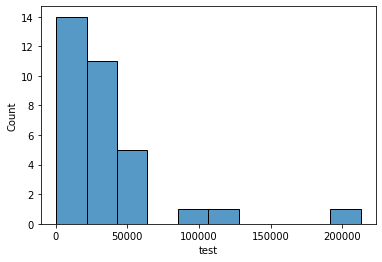

In [35]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [36]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,totvolume,condvenda,valor real,valor predito
dtemissao,,,,,
2022-06-13,15327.830,1323,2,27504.458,32708.688175
2022-06-14,493.933,151,1,15327.830,30421.043504
2022-06-15,18396.396,1516,5,493.933,33722.255960
2022-06-16,261672.826,22405,56,18396.396,73774.486270
2022-06-17,97253.969,8492,37,261672.826,48824.654196


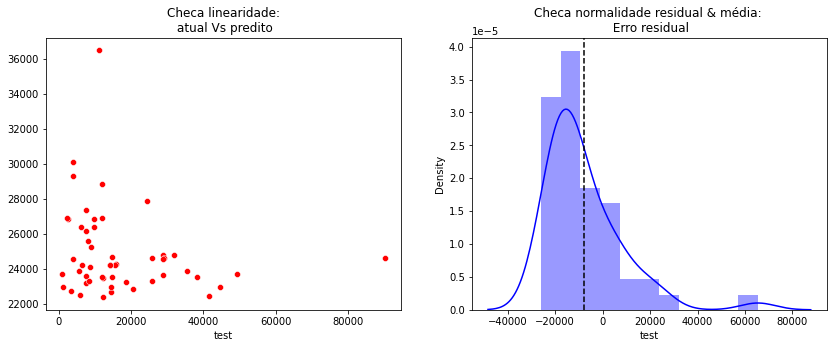

In [ ]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred,ax=ax,color='r')
ax.set_title('Checa linearidade:\n atual Vs predito')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred),ax=ax,color='b')
ax.axvline((y_test - y_pred).mean(),color='k',linestyle='--')
ax.set_title('Checa normalidade residual & média: \n Erro residual');

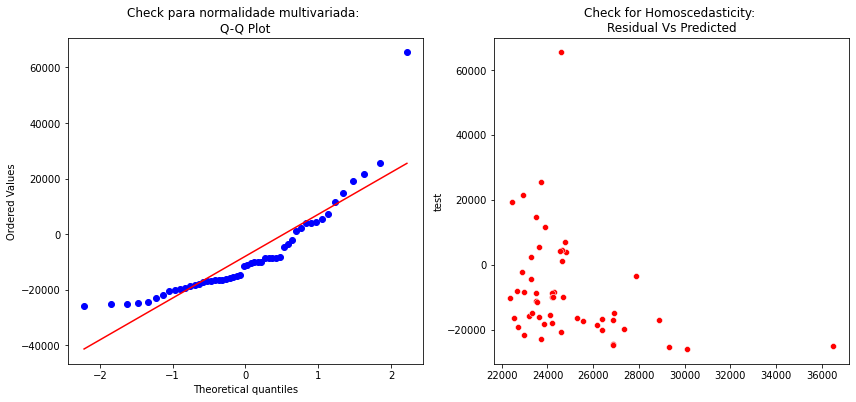

In [ ]:
# Check para normalidade multivariada

f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred),fit=True,plot=ax[0])
ax[0].set_title('Check para normalidade multivariada: \nQ-Q Plot')

#Check for Homoscedasticity
"""
Os dados são homocedásticos, o que significa que os resíduos são iguais 
ao longo da linha de regressão.
Podemos olhar para o gráfico de dispersão de valor ajustado Vs residual.
Se o gráfico heterocedástico exibiria um padrão de forma de funil.
"""
sns.scatterplot(y = (y_test - y_pred), x= y_pred, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

Text(0, 0.5, 'y predito')

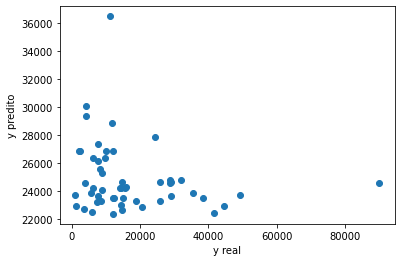

In [ ]:
# Diagrama de dispersão (scatterplot) 
# dos valores reais de teste em relação aos valores preditos.

plt.scatter(y_test, y_pred)
plt.xlabel('y real')
plt.ylabel('y predito')

In [37]:
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

MAE: 35457.48
MSE: 2757850542.35
RMSE: 52515.24
R: 0.07
MAPE: 1076.68
Acurácia: -976.68
mean y_test: 44545.61
median y_test: 24504.65
mean pred: 38809.09
median pred: 35997.04


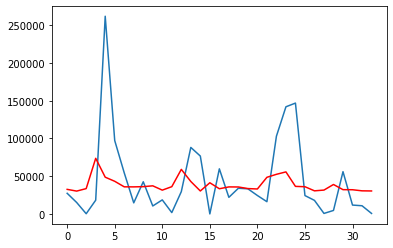

In [38]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

### **Decision Tree**

In [ ]:
X = df[['vltotal']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((155, 1), (52, 1), (155,), (52,))

In [ ]:
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_pred = regressor.predict(X_test)

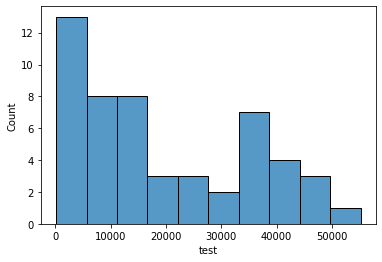

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,valor real,valor predito
dtemissao,,,
2022-06-20,7577.309,38282.083,550.280
2022-06-21,8205.540,7577.309,7409.561
2022-06-22,20613.357,8205.540,2370.840
2022-06-23,3499.620,20613.357,2825.552
2022-06-25,2508.300,3499.620,16897.790


In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

MAE: 19131.34
MSE: 623887865.76
RMSE: 24977.75
R: -1.58
MAPE: 217.49
Acurácia: -117.49
mean y_test: 16972.06
median y_test: 12102.37
mean pred: 22938.38
median pred: 19773.44


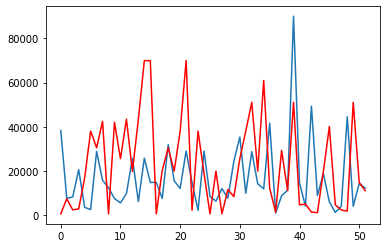

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

### **Random Forest**

In [ ]:
X = df[['vltotal']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((155, 1), (52, 1), (155,), (52,))

In [ ]:
regressor_random_forest = RandomForestRegressor()
regressor_random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred = regressor_random_forest.predict(X_test) 

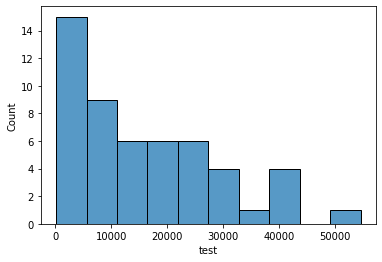

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,valor real,valor predito
dtemissao,,,
2022-06-20,7577.309,38282.083,12716.09075
2022-06-21,8205.540,7577.309,11056.63149
2022-06-22,20613.357,8205.540,34173.95568
2022-06-23,3499.620,20613.357,4389.02408
2022-06-25,2508.300,3499.620,22197.08006


In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

MAE: 16059.42
MSE: 435088972.25
RMSE: 20858.79
R: -0.80
MAPE: 203.27
Acurácia: -103.27
mean y_test: 16972.06
median y_test: 12102.37
mean pred: 22476.97
median pred: 16897.25


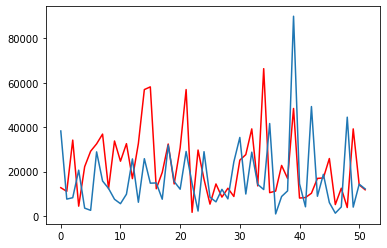

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_pred, color='red')
plt.plot(y_test.values) 

plt.show()

### **XGBoost**

In [ ]:
X = df[['vltotal']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((155, 1), (52, 1), (155,), (52,))

#### **Teste 1**

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor()
 
# Fitting the model
xgb_r.fit(X_train, y_train)
 
# Predict the model
y_pred = xgb_r.predict(X_test) 
 
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

[12:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 13371.09
MSE: 270144225.31
RMSE: 16436.06
R: -0.12
MAPE: 199.73
Acurácia: -99.73
mean y_test: 16972.06
median y_test: 12102.37
mean pred: 21799.32
median pred: 20482.66


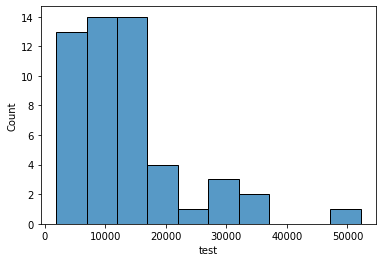

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,valor real,valor predito
dtemissao,,,
2022-06-20,7577.309,38282.083,20482.664062
2022-06-21,8205.540,7577.309,20482.664062
2022-06-22,20613.357,8205.540,18486.728516
2022-06-23,3499.620,20613.357,10189.764648
2022-06-25,2508.300,3499.620,15598.749023


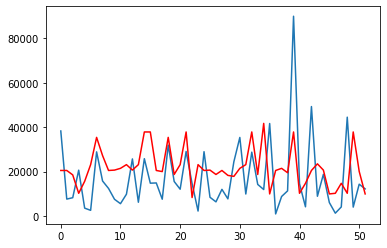

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

#### **Teste 2**

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
 
# Fitting the model
xgb_r.fit(X_train, y_train)
 
# Predict the model
pred = xgb_r.predict(X_test) 
 
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

[12:51:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 13371.09
MSE: 270144225.31
RMSE: 16436.06
R: -0.12
MAPE: 199.73
Acurácia: -99.73
mean y_test: 16972.06
median y_test: 12102.37
mean pred: 21799.32
median pred: 20482.66


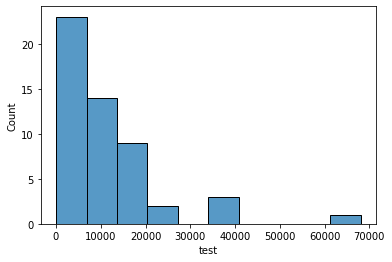

In [ ]:
absolute_error = abs(y_test - pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,valor real,valor predito
dtemissao,,,
2022-06-20,7577.309,38282.083,20482.664062
2022-06-21,8205.540,7577.309,20482.664062
2022-06-22,20613.357,8205.540,18486.728516
2022-06-23,3499.620,20613.357,10189.764648
2022-06-25,2508.300,3499.620,15598.749023


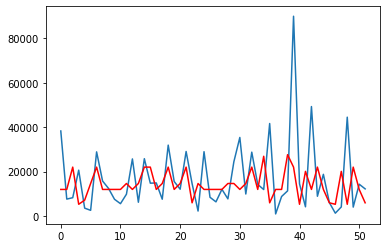

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(pred, color='red')
plt.show()

In [ ]:
saved_model = pickle.dumps(xgb_r)

In [ ]:
xgb_from_pickle = pickle.loads(saved_model)

[13:11:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_from_pickle.predict(X_test)

#### **Testando com novos dados**

In [14]:
df_2348 = dataframe[dataframe['codvendedor'] == '2348']
df_2348.head()

,numpedido,numcarga,numnota,condvenda,posicao,dtemissao,vltotal,vltabela,codcli,codvendedor,codfilial,codfilialnf,codplpag,codcob,origem,motorista,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,pedido_id,chave_nfe,perc_comissao,numpedidotv1,dtemissaonf,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho
1087,8903063,230288.0,4632892.0,1,F,2021-11-08,9936.19,9936.19,22580,2348,0,0,102,3,F,NaN,NaN,NaN,214.467,1039,15e526b2-4334-48dd-a73a-621c7dbed8c0,NaN,NaN,NaN,2021-11-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,8903075,85087.0,NaN,1,M,2021-11-08,14.82,14.82,22580,2348,0,0,102,3,F,MOTORISTA - PADRAO NC 219496,NaN,NaN,0.055,1,15e526b2-4334-48dd-a73a-621c7dbed8c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1126,8904440,230600.0,NaN,1,M,2021-11-09,1851.11,1851.11,17814,2348,0,0,7,3,F,CARLOS HENRIQUE DA SILVA,NaN,NaN,5.215,103,95681508-0cee-4282-a8c7-a4fd60b78f83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1127,8904151,230600.0,NaN,1,M,2021-11-09,192.90,192.90,17814,2348,0,0,7,3,F,CARLOS HENRIQUE DA SILVA,NaN,NaN,0.250,10,dd0a74f3-e438-416d-a845-92ed88aa47a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1131,8911377,NaN,NaN,1,R,2021-11-10,8061.93,8061.93,28802,2348,0,0,102,3,F,NaN,NaN,NaN,116.118,837,440cff42-cd40-4203-a0a5-72a04d89c551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fig = px.line(df_2348, x="dtemissao", y=["vltotal"])
fig.show()

In [15]:
df_2348.shape

(1674, 40)

In [16]:
df = df_2348.groupby(df_2348['dtemissao']).sum()
df.shape

(129, 32)

In [17]:
# Criando janela de tempo 1 dia anterior

window = -1
history = [df['vltotal'].values[i] for i in range(window)]
test = [df['vltotal'].values[i] for i in range(window, len(df['vltotal'].values))]

In [18]:
len(test)

130

In [19]:
test.pop(129)

439.94

In [20]:
len(test)

129

In [21]:
df['test'] = test
df.head()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test
dtemissao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-08,17806138,315375.0,4632892.0,2,9951.01,9951.01,45160,0,0,204,6,0.0,0.0,214.522,1040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.94
2021-11-09,17808591,461200.0,0.0,2,2044.01,2044.01,35628,0,0,14,6,0.0,0.0,5.465,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9951.01
2021-11-10,8911377,0.0,0.0,1,8061.93,8061.93,28802,0,0,102,3,0.0,0.0,116.118,837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2044.01
2021-11-11,98040842,2306114.0,46391181.0,11,5976.70,5976.70,93603,0,0,76,33,0.0,0.0,118.068,610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8061.93
2021-11-12,17831994,461266.0,9278817.0,2,14547.54,14547.54,57604,0,0,204,6,0.0,0.0,228.030,1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5976.70


In [22]:
df_2348.describe()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho
count,1.674000e+03,1579.000000,1.577000e+03,1674.0,1674.000000,1674.000000,1674.000000,1674.0,1674.0,1674.000000,1674.0,0.0,0.0,1674.000000,1674.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,9.283137e+06,239131.314123,4.795346e+06,1.0,3036.549753,3040.417091,11838.644564,0.0,0.0,105.535842,3.0,NaN,NaN,105.319421,248.214456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.956360e+05,6096.528909,8.348147e+04,0.0,5572.363427,5586.939220,9881.852782,0.0,0.0,77.001705,0.0,NaN,NaN,281.553088,449.031344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,8.903063e+06,85087.000000,4.632892e+06,1.0,0.000000,0.000000,405.000000,0.0,0.0,4.000000,3.0,NaN,NaN,0.055000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,9.139892e+06,235703.000000,4.734464e+06,1.0,513.742000,513.741825,3024.000000,0.0,0.0,7.000000,3.0,NaN,NaN,11.161750,36.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,9.325220e+06,240326.000000,4.815517e+06,1.0,1378.234500,1378.233600,6074.000000,0.0,0.0,141.000000,3.0,NaN,NaN,26.560000,108.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9.451770e+06,243338.000000,4.868206e+06,1.0,3351.011750,3351.012425,19010.000000,0.0,0.0,141.000000,3.0,NaN,NaN,74.310750,273.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,9.606992e+06,247127.000000,4.931488e+06,1.0,104347.960000,104347.960000,39145.000000,0.0,0.0,324.000000,3.0,NaN,NaN,3191.160000,6322.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
X = df[['vltotal', 'totvolume', 'condvenda']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 3), (33, 3), (96,), (33,))

In [ ]:
pred = xgb_from_pickle.predict(X)

In [ ]:
y.shape

(129,)

In [ ]:
pred.shape

(129,)

In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y, pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y, pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y, pred)):.2f}')
print(f'R: {metrics.r2_score(y, pred):.2f}')
MAPE = np.mean(100 * (np.abs(y-pred)/y))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y.mean():.2f}')
print(f'median y_test: {y.median():.2f}')
print(f'mean pred: {pred.mean():.2f}')
print(f'median pred: {np.median(pred):.2f}')

MAE: 33698.20
MSE: 3681701702.88
RMSE: 60677.03
R: -0.17
MAPE: inf
Acurácia: -inf
mean y_test: 39404.53
median y_test: 15986.29
mean pred: 18371.86
median pred: 14606.16


In [ ]:
y

dtemissao
2021-11-08       439.940
2021-11-09      9951.010
2021-11-10      2044.010
2021-11-11      8061.930
2021-11-12      5976.700
2021-11-17     14547.540
2021-11-23      3940.650
2021-11-24    153079.696
2021-11-25     15986.290
2021-11-29     58520.608
2021-11-30     59424.691
2021-12-01    206087.819
2021-12-02     16720.250
2021-12-03     16720.250
2021-12-13     11603.900
2021-12-15      8565.820
2021-12-16      7603.821
2021-12-17      3788.676
2021-12-21      5527.530
2021-12-22     20878.540
2021-12-23     36650.395
2021-12-28      5820.360
2021-12-29      5390.316
2021-12-30    210929.256
2021-12-31    156186.198
2022-01-04      3107.799
2022-01-11      5403.240
2022-01-14     12255.740
2022-01-17      7248.550
2022-01-18     28309.660
2022-01-19      6343.880
2022-01-21      5098.145
2022-01-25      5571.540
2022-01-26      7665.915
2022-01-28      4934.270
2022-01-29     24409.480
2022-01-31     52219.477
2022-02-03     30404.470
2022-02-07    104347.960
2022-02-08     

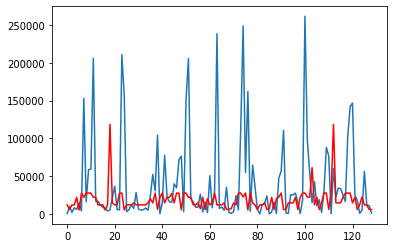

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y.values) 
plt.plot(pred, color='red')
plt.show()

In [ ]:
df.head()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,...,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test
dtemissao,,,,,,,,,,,,,,,,,,,,,
2021-11-08,17806138,315375.0,4632892.0,2,9951.01,9951.01,45160,0,0,204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.94
2021-11-09,17808591,461200.0,0.0,2,2044.01,2044.01,35628,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9951.01
2021-11-10,8911377,0.0,0.0,1,8061.93,8061.93,28802,0,0,102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2044.01
2021-11-11,98040842,2306114.0,46391181.0,11,5976.70,5976.70,93603,0,0,76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8061.93
2021-11-12,17831994,461266.0,9278817.0,2,14547.54,14547.54,57604,0,0,204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5976.70


In [ ]:
Test_Data=df
 
TestingData=pd.DataFrame(data=df)
TestingData['valor real']=y
TestingData['valor predito']=pred
TestingData.head()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,...,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test,valor real,valor predito
dtemissao,,,,,,,,,,,,,,,,,,,,,
2021-11-08,17806138,315375.0,4632892.0,2,9951.01,9951.01,45160,0,0,204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.94,439.94,11933.179688
2021-11-09,17808591,461200.0,0.0,2,2044.01,2044.01,35628,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9951.01,9951.01,5901.478516
2021-11-10,8911377,0.0,0.0,1,8061.93,8061.93,28802,0,0,102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2044.01,2044.01,11933.179688
2021-11-11,98040842,2306114.0,46391181.0,11,5976.70,5976.70,93603,0,0,76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8061.93,8061.93,11933.179688
2021-11-12,17831994,461266.0,9278817.0,2,14547.54,14547.54,57604,0,0,204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5976.70,5976.70,21991.246094


### **SVR**

In [ ]:
X = df[['vltotal']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((155, 1), (52, 1), (155,), (52,))

#### **Teste 1**

In [ ]:
regressor_svr = SVR()
regressor_svr.fit(X_train, y_train)

SVR()

In [ ]:
y_pred = regressor_svr.predict(X_test)

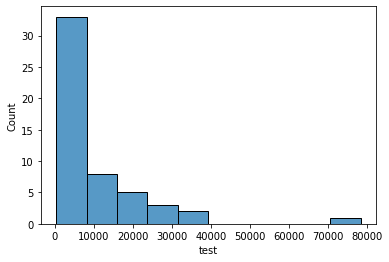

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,valor real,valor predito
dtemissao,,,
2022-06-20,7577.309,38282.083,11574.726473
2022-06-21,8205.540,7577.309,11574.872888
2022-06-22,20613.357,8205.540,11578.068447
2022-06-23,3499.620,20613.357,11573.841123
2022-06-25,2508.300,3499.620,11573.645106


In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

MAE: 10182.57
MSE: 271232031.71
RMSE: 16469.12
R: -0.12
MAPE: 107.25
Acurácia: -7.25
mean y_test: 16972.06
median y_test: 12102.37
mean pred: 11576.65
median pred: 11575.80


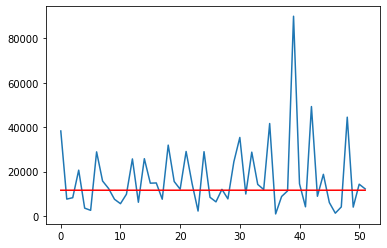

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

#### **Teste 2**

In [ ]:
regressor_svr = SVR(kernel = 'rbf', C=10.0, cache_size=200, coef0=0.0, epsilon=0.07, gamma='scale')
regressor_svr.fit(X_train, y_train)

SVR(C=10.0, epsilon=0.07)

In [ ]:
y_pred = regressor_svr.predict(X_test)

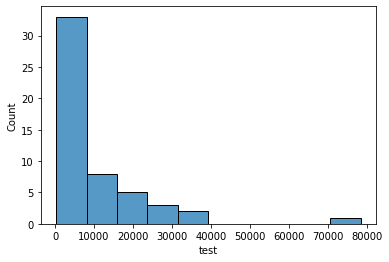

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,valor real,valor predito
dtemissao,,,
2022-06-20,7577.309,38282.083,11545.160890
2022-06-21,8205.540,7577.309,11546.605319
2022-06-22,20613.357,8205.540,11578.083209
2022-06-23,3499.620,20613.357,11536.420761
2022-06-25,2508.300,3499.620,11534.484089


In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

MAE: 10192.27
MSE: 271549090.99
RMSE: 16478.75
R: -0.12
MAPE: 107.20
Acurácia: -7.20
mean y_test: 16972.06
median y_test: 12102.37
mean pred: 11564.07
median pred: 11555.77


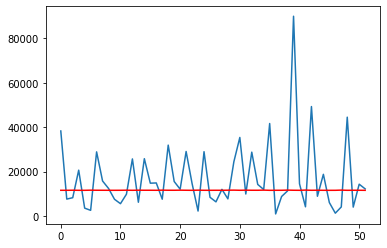

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

### **Adaboost**

In [ ]:
df.head()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test
dtemissao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-08,17806138,315375.0,4632892.0,2,9951.01,9951.01,45160,0,0,204,6,0.0,0.0,214.522,1040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.94
2021-11-09,17808591,461200.0,0.0,2,2044.01,2044.01,35628,0,0,14,6,0.0,0.0,5.465,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9951.01
2021-11-10,8911377,0.0,0.0,1,8061.93,8061.93,28802,0,0,102,3,0.0,0.0,116.118,837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2044.01
2021-11-11,98040842,2306114.0,46391181.0,11,5976.70,5976.70,93603,0,0,76,33,0.0,0.0,118.068,610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8061.93
2021-11-12,17831994,461266.0,9278817.0,2,14547.54,14547.54,57604,0,0,204,6,0.0,0.0,228.030,1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5976.70


In [ ]:
X = df[['vltotal']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 1), (33, 1), (96,), (33,))

In [ ]:
# Instantiation
ada = AdaBoostRegressor(random_state=0, n_estimators=100)
 
# Fitting the model
ada.fit(X_train, y_train)
 
# Predict the model
y_pred = ada.predict(X_test) 
 
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

MAE: 48811.39
MSE: 4192020768.97
RMSE: 64745.82
R: -0.42
MAPE: 1830.96
Acurácia: -1730.96
mean y_test: 44545.61
median y_test: 24504.65
mean pred: 54049.84
median pred: 45092.29


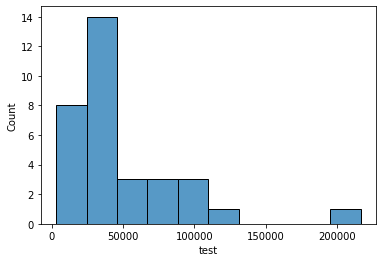

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,valor real,valor predito
dtemissao,,,
2022-06-13,15327.830,27504.458,24465.144909
2022-06-14,493.933,15327.830,46502.746583
2022-06-15,18396.396,493.933,109983.997361
2022-06-16,261672.826,18396.396,70981.260167
2022-06-17,97253.969,261672.826,45092.290958


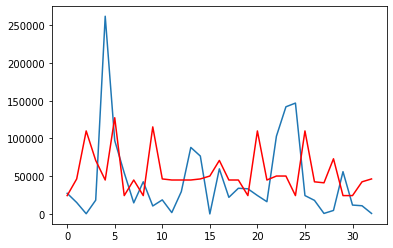

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

In [ ]:
ada.score(X, y)

0.25450506588209

In [ ]:
df.describe()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test
count,1.290000e+02,1.290000e+02,1.290000e+02,129.000000,129.000000,129.000000,1.290000e+02,129.0,129.0,129.000000,129.000000,129.0,129.0,129.000000,129.000000,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.000000
mean,1.204649e+08,2.927041e+06,5.862218e+07,12.976744,39404.529349,39454.714809,1.536271e+05,0.0,0.0,1369.511628,38.930233,0.0,0.0,1366.703180,3221.015504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39404.529349
std,1.785136e+08,4.522181e+06,9.067755e+07,19.234354,56215.107902,56331.188255,2.015134e+05,0.0,0.0,2781.625983,57.703063,0.0,0.0,2931.612204,4698.852290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56215.107902
min,8.911377e+06,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,4.050000e+02,0.0,0.0,4.000000,3.000000,0.0,0.0,0.350000,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,9.578047e+06,2.394310e+05,4.775332e+06,1.000000,5571.540000,5571.540000,2.896800e+04,0.0,0.0,14.000000,3.000000,0.0,0.0,123.709000,437.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5571.540000
50%,3.604950e+07,7.111770e+05,1.430549e+07,4.000000,15986.290000,15986.290600,6.804800e+04,0.0,0.0,133.000000,12.000000,0.0,0.0,378.430000,1439.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15986.290000
75%,1.730449e+08,4.416463e+06,8.880290e+07,19.000000,47488.282000,47488.265300,1.825000e+05,0.0,0.0,1269.000000,57.000000,0.0,0.0,1141.563000,3763.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47488.282000
max,9.101145e+08,2.342178e+07,4.684568e+08,96.000000,261672.826000,261672.844100,1.086025e+06,0.0,0.0,16018.000000,288.000000,0.0,0.0,19209.288000,23600.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,261672.826000


## **Feature Eng**

In [ ]:
TestingData.head()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,...,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test,valor real,valor predito
dtemissao,,,,,,,,,,,,,,,,,,,,,
2021-11-08,17806138,315375.0,4632892.0,2,9951.01,9951.01,45160,0,0,204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.94,439.94,11933.179688
2021-11-09,17808591,461200.0,0.0,2,2044.01,2044.01,35628,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9951.01,9951.01,5901.478516
2021-11-10,8911377,0.0,0.0,1,8061.93,8061.93,28802,0,0,102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2044.01,2044.01,11933.179688
2021-11-11,98040842,2306114.0,46391181.0,11,5976.70,5976.70,93603,0,0,76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8061.93,8061.93,11933.179688
2021-11-12,17831994,461266.0,9278817.0,2,14547.54,14547.54,57604,0,0,204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5976.70,5976.70,21991.246094


In [ ]:
TestingData['diff'] = abs(TestingData['valor real'] - TestingData['valor predito'])
TestingData.head()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,...,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test,valor real,valor predito,diff
dtemissao,,,,,,,,,,,,,,,,,,,,,
2021-11-08,17806138,315375.0,4632892.0,2,9951.01,9951.01,45160,0,0,204,...,0.0,0.0,0.0,0.0,0.0,0.0,439.94,439.94,11933.179688,11493.239687
2021-11-09,17808591,461200.0,0.0,2,2044.01,2044.01,35628,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,9951.01,9951.01,5901.478516,4049.531484
2021-11-10,8911377,0.0,0.0,1,8061.93,8061.93,28802,0,0,102,...,0.0,0.0,0.0,0.0,0.0,0.0,2044.01,2044.01,11933.179688,9889.169687
2021-11-11,98040842,2306114.0,46391181.0,11,5976.70,5976.70,93603,0,0,76,...,0.0,0.0,0.0,0.0,0.0,0.0,8061.93,8061.93,11933.179688,3871.249687
2021-11-12,17831994,461266.0,9278817.0,2,14547.54,14547.54,57604,0,0,204,...,0.0,0.0,0.0,0.0,0.0,0.0,5976.70,5976.70,21991.246094,16014.546094


In [ ]:
TestingData['diff'].describe()

count       129.000000
mean      33698.201080
std       50655.943487
min           4.335312
25%        6086.583094
50%       12250.157484
75%       30816.698312
max      234071.320141
Name: diff, dtype: float64

In [ ]:
TestingData[TestingData['diff'] >= 6000]

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test,valor real,valor predito,diff
dtemissao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-08,17806138,315375.0,4632892.0,2,9951.010,9951.0100,45160,0,0,204,6,0.0,0.0,214.5220,1040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.940,439.940,11933.179688,11493.239687
2021-11-10,8911377,0.0,0.0,1,8061.930,8061.9300,28802,0,0,102,3,0.0,0.0,116.1180,837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2044.010,2044.010,11933.179688,9889.169687
2021-11-12,17831994,461266.0,9278817.0,2,14547.540,14547.5400,57604,0,0,204,6,0.0,0.0,228.0300,1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5976.700,5976.700,21991.246094,16014.546094
2021-11-17,8924421,0.0,0.0,1,3940.650,3940.6500,405,0,0,7,3,0.0,0.0,117.2580,367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14547.540,14547.540,5235.764648,9311.775352
2021-11-23,169801511,4391042.0,88324015.0,19,153079.696,153079.7136,182500,0,0,3420,57,0.0,0.0,11329.7700,12642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3940.650,3940.650,27601.505859,23660.855859
2021-11-24,35758010,924771.0,18601176.0,4,15986.290,15986.2906,111489,0,0,20,12,0.0,0.0,290.3360,1477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153079.696,153079.696,21991.246094,131088.449906
2021-11-25,196775523,4625180.0,93033468.0,22,58520.608,58520.6067,225952,0,0,2697,66,0.0,0.0,2021.8720,3763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15986.290,15986.290,27601.505859,11615.215859
2021-11-29,349142009,9028162.0,181557120.0,39,59424.691,59424.6720,373417,0,0,5499,117,0.0,0.0,2621.1950,8564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58520.608,58520.608,27601.505859,30919.102141
2021-11-30,725517068,18291025.0,367805991.0,81,206087.819,205736.3343,895256,0,0,11166,243,0.0,0.0,4304.4950,14058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59424.691,59424.691,27601.505859,31823.185141


In [ ]:
df.isnull().sum().sort_values(ascending = False)[:15]

numpedido             0
numcarga              0
perc_lucratividade    0
numpedorigem          0
vlfrete               0
dtabertura            0
dtfechamento          0
codsegmento           0
codtabvenda           0
codplpagetico         0
codplpaggenerico      0
codmotorista          0
fretedespacho         0
freteredespacho       0
test                  0
dtype: int64

In [ ]:
# Ver correlação com o target 'y'

y = df['test']
X = df[df.columns.difference(['test'])]

df_corr = X.copy()
df_corr['test'] = y 
df_corr.corr()['test'].apply(abs).sort_values(ascending=False)[:20]

valor real                  1.000000
test                        1.000000
diff                        0.952961
codplpag                    0.226636
numnota                     0.224408
numcarga                    0.224257
totpeso                     0.215887
vltabela                    0.215371
totvolume                   0.214815
vltotal                     0.214486
numpedido                   0.209223
condvenda                   0.207255
codcob                      0.207255
codcli                      0.205986
valor predito               0.074660
codfilial                        NaN
codfilialnf                      NaN
codfornecfrete                   NaN
codfornecfreteredespacho         NaN
codmotorista                     NaN
Name: test, dtype: float64

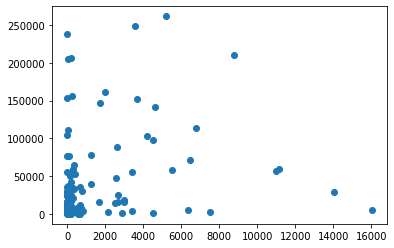

In [ ]:
plt.scatter(x=df['codplpag'], y=df['test'])

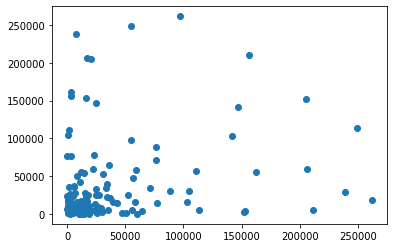

In [ ]:
plt.scatter(x=df['vltotal'], y=df['test'])

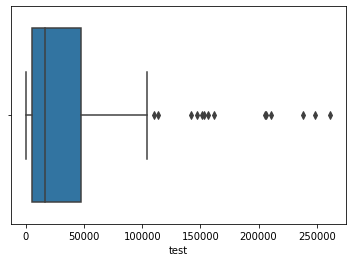

In [ ]:
# Box Plot
import seaborn as sns
sns.boxplot(df['test'])

In [ ]:
# Position of the Outlier
print(np.where(df['test']>100000))

(array([  7,  11,  23,  24,  38,  50,  51,  63,  73,  74,  76,  91, 100,
       118, 119, 120]),)


In [ ]:
# Z score
from scipy import stats
import numpy as np
 
z = np.abs(stats.zscore(df['test']))
print(z)

dtemissao
2021-11-08    0.695836
2021-11-09    0.525986
2021-11-10    0.667190
2021-11-11    0.559721
2021-11-12    0.596960
2021-11-17    0.443900
2021-11-23    0.633320
2021-11-24    2.030030
2021-11-25    0.418207
2021-11-29    0.341378
2021-11-30    0.357523
2021-12-01    2.976658
2021-12-02    0.405100
2021-12-03    0.405100
2021-12-13    0.496468
2021-12-15    0.550723
2021-12-16    0.567902
2021-12-17    0.636034
2021-12-21    0.604981
2021-12-22    0.330840
2021-12-23    0.049184
2021-12-28    0.599752
2021-12-29    0.607431
2021-12-30    3.063117
2021-12-31    2.085506
2022-01-04    0.648193
2022-01-11    0.607201
2022-01-14    0.484828
2022-01-17    0.574247
2022-01-18    0.198134
2022-01-19    0.590403
2022-01-21    0.612649
2022-01-25    0.604195
2022-01-26    0.566793
2022-01-28    0.615576
2022-01-29    0.267784
2022-01-31    0.228851
2022-02-03    0.160725
2022-02-07    1.159770
2022-02-08    0.698194
2022-02-09    0.446903
2022-02-10    0.682244
2022-02-11    0.296591
2

In [ ]:
# IQR
Q1 = np.percentile(df['test'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['test'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [ ]:
IQR

41916.742

In [ ]:
# Above Upper bound
upper = df['test'] >= (Q3+1.5*IQR)
 
print("Upper bound:",upper)
print(np.where(upper))
 
# Below Lower bound
lower = df['test'] <= (Q1-1.5*IQR)
print("Lower bound:", lower)
print(np.where(lower))

In [ ]:
df['data'] = df.index

In [ ]:
df.shape

(129, 34)

In [ ]:
df.index = pd.Index(range(129))

In [ ]:
# Importing
import sklearn

''' Detection '''
# IQR
Q1 = np.percentile(df['test'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['test'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['test'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['test'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

Old Shape:  (129, 34)
New Shape:  (115, 34)


#### **XGBoost**

In [ ]:
X = df[['vltotal']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((86, 1), (29, 1), (86,), (29,))

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
 
# Fitting the model
xgb_r.fit(X_train, y_train)
 
# Predict the model
y_pred = xgb_r.predict(X_test) 
 
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

[19:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 23400.01
MSE: 1107615449.58
RMSE: 33280.86
R: -0.29
MAPE: 602.96
Acurácia: -502.96
mean y_test: 30762.12
median y_test: 18799.79
mean pred: 14972.30
median pred: 13313.76


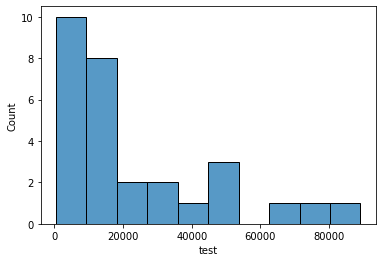

In [ ]:
absolute_error = abs(y_test - pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,valor real,valor predito
97,493.933,15327.830,7207.307129
98,18396.396,493.933,10015.958984
99,261672.826,18396.396,16019.536133
101,54554.617,97253.969,18603.017578
102,14866.816,54554.617,8358.286133


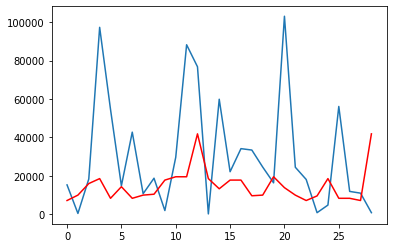

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(pred, color='red')
plt.show()

### **Usando mais features**

In [ ]:
X = df[['vltotal',
        'codplpag',
        'numnota',
        'numcarga',
        'totpeso',
        'vltabela',
        'totvolume',
        'numpedido',
        'condvenda',
        'codcob',
        'codcli']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 11), (33, 11), (96,), (33,))

##### **XGBoost**
vendedor 1106

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
 
# Fitting the model
xgb_r.fit(X_train, y_train)
 
# Predict the model
y_pred = xgb_r.predict(X_test) 
 
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

[19:15:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 12373.24
MSE: 413226800.28
RMSE: 20327.98
R: -0.71
MAPE: 287.23
Acurácia: -187.23
mean y_test: 16972.06
median y_test: 12102.37
mean pred: 17931.91
median pred: 17500.82


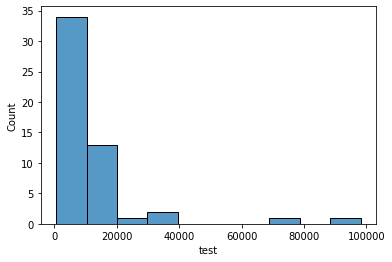

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,codplpag,numnota,numcarga,totpeso,vltabela,totvolume,numpedido,condvenda,codcob,codcli,valor real,valor predito
dtemissao,,,,,,,,,,,,,
2022-06-20 00:00:00,7577.309,742,48707770.0,2434714.0,418.027,7577.3072,1252,103986416,11,33,268270,38282.083,18722.275391
2022-06-21 00:00:00,8205.540,485,73075320.0,3652730.0,619.403,8205.5406,1469,141879280,15,45,270551,7577.309,18722.275391
2022-06-22 00:00:00,20613.357,447,63350491.0,3166725.0,958.136,20613.3565,3126,123021162,13,39,363832,8205.540,18722.275391
2022-06-23 00:00:00,3499.620,102,4874666.0,243697.0,22.092,3499.6200,198,9466694,1,3,22580,20613.357,9025.934570
2022-06-25 00:00:00,2508.300,7,0.0,0.0,239.325,2508.3000,270,9468188,1,3,17814,3499.620,6650.337402


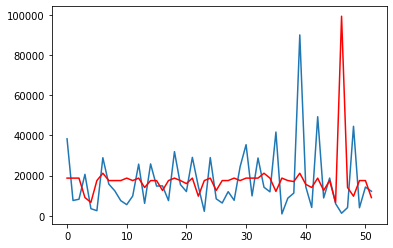

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

In [ ]:
model_xgb = pickle.dumps(xgb_r)

In [ ]:
xgb_from_pickle = pickle.loads(model_xgb)

[19:17:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#TESTANDO COM NOVO VENDEDOR 2348 - RODAR A PARTE DESSE VENDEDOR 
y_pred = xgb_from_pickle.predict(X_test)

In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

MAE: 38141.26
MSE: 3991297855.85
RMSE: 63176.72
R: -0.35
MAPE: 1501.80
Acurácia: -1401.80
mean y_test: 44545.61
median y_test: 24504.65
mean pred: 16636.43
median pred: 12571.05


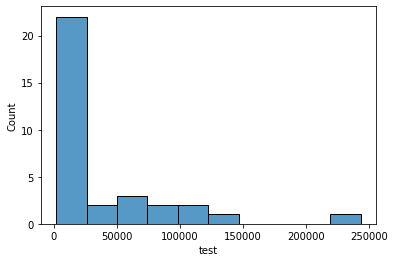

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,codplpag,numnota,numcarga,totpeso,vltabela,totvolume,numpedido,condvenda,codcob,codcli,valor real,valor predito
dtemissao,,,,,,,,,,,,,
2022-06-13 00:00:00,15327.830,10,4863156.0,243024.0,541.856,15327.8300,1323,18872900,2,6,39550,27504.458,9499.573242
2022-06-14 00:00:00,493.933,7,0.0,0.0,45.139,493.9328,151,9440280,1,3,21044,15327.830,9025.934570
2022-06-15 00:00:00,18396.396,705,24333839.0,1216160.0,384.438,18396.3985,1516,47239617,5,15,76021,493.933,13792.512695
2022-06-16 00:00:00,261672.826,2982,184942954.0,9242994.0,19209.288,261672.8441,22405,529132181,56,168,532873,18396.396,8862.893555
2022-06-17 00:00:00,97253.969,5217,180125541.0,9003780.0,1445.484,97253.9678,8492,349665501,37,111,359204,261672.826,18722.275391


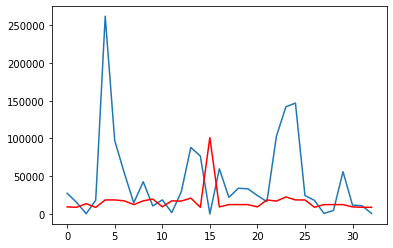

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

### **Linear Regression**

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
# R2 para Regressão Linear

regressor.score(X_train, y_train)

0.1508399818045999

In [ ]:
y_pred = regressor.predict(X_test)

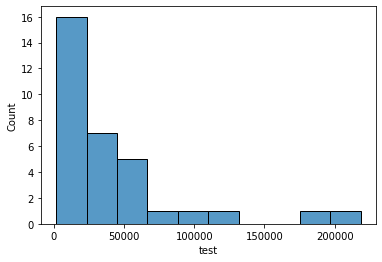

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,codplpag,numnota,numcarga,totpeso,vltabela,totvolume,numpedido,condvenda,codcob,codcli,valor real,valor predito
dtemissao,,,,,,,,,,,,,
2022-06-13 00:00:00,15327.830,10,4863156.0,243024.0,541.856,15327.8300,1323,18872900,2,6,39550,27504.458,23912.302826
2022-06-14 00:00:00,493.933,7,0.0,0.0,45.139,493.9328,151,9440280,1,3,21044,15327.830,21161.752852
2022-06-15 00:00:00,18396.396,705,24333839.0,1216160.0,384.438,18396.3985,1516,47239617,5,15,76021,493.933,39950.341769
2022-06-16 00:00:00,261672.826,2982,184942954.0,9242994.0,19209.288,261672.8441,22405,529132181,56,168,532873,18396.396,-55438.820832
2022-06-17 00:00:00,97253.969,5217,180125541.0,9003780.0,1445.484,97253.9678,8492,349665501,37,111,359204,261672.826,43228.957501


In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

MAE: 40765.18
MSE: 4091804918.52
RMSE: 63967.22
R: -0.38
MAPE: 1141.95
Acurácia: -1041.95
mean y_test: 44545.61
median y_test: 24504.65
mean pred: 42647.12
median pred: 37470.28


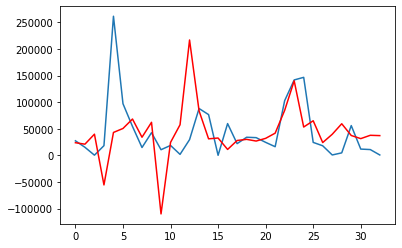

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

### **Foward Selection**

##### **Com RL**

In [40]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

In [41]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [42]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [43]:
df.head(1)

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test
dtemissao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-08,17806138,315375.0,4632892.0,2,9951.01,9951.01,45160,0,0,204,6,0.0,0.0,214.522,1040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,439.94


In [44]:
X = df[['vltotal',
        'codplpag',
        'numnota',
        'numcarga',
        'totpeso',
        'vltabela',
        'totvolume',
        'numpedido',
        'condvenda',
        'codcob',
        'codcli',
        'codfilial',
        'codfilialnf',
        'codfornecfrete',
        'codfornecfreteredespacho',
        'perc_comissao',
        'numpedidotv1',
        'obs',
        'obs_entrega',
        'perc_lucratividade',
        'numpedorigem',
        'vlfrete',
        'dtabertura',
        'dtfechamento',
        'codsegmento',
        'codtabvenda',
        'codplpagetico',
        'codplpaggenerico',
        'codmotorista',
        'fretedespacho',
        'freteredespacho'
        ]]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 31), (33, 31), (96,), (33,))

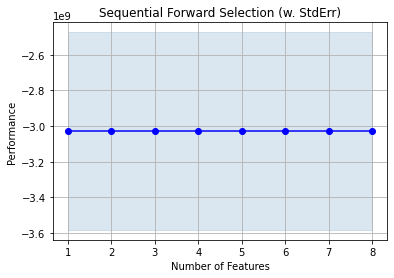

In [45]:
lr = LinearRegression()

sfs = SequentialFeatureSelector(lr, 
          k_features=8, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
sfs.k_feature_names_

('vltotal',
 'numnota',
 'numcarga',
 'vltabela',
 'totvolume',
 'condvenda',
 'codcob',
 'codcli')

In [ ]:
sfs.k_score_

-3160295978.070268

In [ ]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)","[-4118042447.816607, -3673487326.1510053, -982...",-3027779098.13514,"(vltabela,)",1235730600.362766,1663806453.452854,554602151.150951
2,"(5, 6)","[-4113898766.256749, -3678843238.128591, -9838...",-3033664806.288131,"(vltabela, totvolume)",1238258001.905226,1667209385.285713,555736461.761904
3,"(0, 5, 6)","[-4086374160.365781, -4084878682.892229, -1007...",-3043214821.664776,"(vltotal, vltabela, totvolume)",1249355727.956304,1682151532.236686,560717177.412229
4,"(0, 5, 6, 10)","[-4062250118.8849277, -4268840771.5886807, -93...",-3106924027.888728,"(vltotal, vltabela, totvolume, codcli)",1221591008.631829,1644768692.338729,548256230.779576
5,"(0, 2, 5, 6, 10)","[-4274592957.1116867, -4355330767.565151, -937...",-3140513603.818059,"(vltotal, numnota, vltabela, totvolume, codcli)",1219560582.167264,1642034895.300755,547344965.100252
6,"(0, 2, 5, 6, 8, 10)","[-4111118014.2869034, -4145281485.004073, -928...",-3133300573.517516,"(vltotal, numnota, vltabela, totvolume, condve...",1156585003.750972,1557243619.800906,519081206.600302
7,"(0, 2, 5, 6, 8, 9, 10)","[-4111118014.2869115, -4145281485.0041056, -92...",-3133300573.517541,"(vltotal, numnota, vltabela, totvolume, condve...",1156585003.750966,1557243619.800898,519081206.600299
8,"(0, 2, 3, 5, 6, 8, 9, 10)","[-4304909274.517094, -4163093768.2043858, -929...",-3160295978.070268,"(vltotal, numnota, numcarga, vltabela, totvolu...",1166125187.013999,1570088667.479977,523362889.159992


##### **Com XGBoost**

In [46]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)

In [47]:
sfsxg = SequentialFeatureSelector(xgb_r, k_features=(1,11), 
          forward=True, 
          floating=False, 
          verbose=2,
          scoring='neg_mean_squared_error',
          cv=10)
sfsxg.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[12:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    2.4s finished

[2022-08-23 12:29:06] Features: 1/11 -- score: -2993206363.1061482[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.3s finished

[2022-08-23 12:29:08] Features: 2/11 -- score: -2985335697.2313476[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    2.2s finished

[2022-08-23 12:29:10] Features: 3/11 -- score: -2936461344.093568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.2s finished

[2022-08-23 12:29:12] Features: 4/11 -- score: -2936461344.093568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.1s finished

[2022-08-23 12:29:14] Features: 5/11 -- score: -2936461344.093568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    2.1s finished

[2022-08-23 12:29:16] Features: 6/11 -- score: -2936461344.093568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.0s finished

[2022-08-23 12:29:18] Features: 7/11 -- score: -2936461344.093568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.9s finished

[2022-08-23 12:29:20] Features: 8/11 -- score: -2936461344.093568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    1.9s finished

[2022-08-23 12:29:22] Features: 9/11 -- score: -2936461344.093568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.0s finished

[2022-08-23 12:29:24] Features: 10/11 -- score: -2936461344.093568[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[12:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    2.7s finished

[2022-08-23 12:29:27] Features: 11/11 -- score: -2936461344.093568

SequentialFeatureSelector(cv=10,
                          estimator=XGBRegressor(n_estimators=10, seed=123),
                          k_features=(1, 11), scoring='neg_mean_squared_error',
                          verbose=2)

In [48]:
sfsxg.k_feature_names_

('vltotal', 'totvolume', 'condvenda')

In [ ]:
sfsxg.k_score_

-2936461344.093568

In [ ]:
pd.DataFrame.from_dict(sfsxg.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[-4820864059.861674, -2595718614.204276, -6953...",-2993206363.106148,"(condvenda,)",1338187218.533371,1801755600.670835,600585200.223612
2,"(0, 8)","[-4848902788.866759, -2781220253.1755667, -811...",-2985335697.231348,"(vltotal, condvenda)",1419131215.497055,1910739827.877728,636913275.959243
3,"(0, 6, 8)","[-4967714241.827521, -2326909227.5469074, -847...",-2936461344.093568,"(vltotal, totvolume, condvenda)",1375198868.366922,1851588648.284871,617196216.094957
4,"(0, 5, 6, 8)","[-4967714241.827521, -2326909227.5469074, -847...",-2936461344.093568,"(vltotal, vltabela, totvolume, condvenda)",1375198868.366922,1851588648.284871,617196216.094957
5,"(0, 5, 6, 8, 9)","[-4967714241.827521, -2326909227.5469074, -847...",-2936461344.093568,"(vltotal, vltabela, totvolume, condvenda, codcob)",1375198868.366922,1851588648.284871,617196216.094957
6,"(0, 4, 5, 6, 8, 9)","[-4937814112.906718, -3016143031.40491, -85021...",-3035540025.691305,"(vltotal, totpeso, vltabela, totvolume, condve...",1367033274.800277,1840594369.05567,613531456.35189
7,"(0, 4, 5, 6, 8, 9, 10)","[-4885386650.034708, -3084742233.892207, -8089...",-3074165091.021958,"(vltotal, totpeso, vltabela, totvolume, condve...",1372893620.014791,1848484826.882407,616161608.960802
8,"(0, 1, 4, 5, 6, 8, 9, 10)","[-4957800956.650584, -3530172430.7822337, -825...",-3165542347.212943,"(vltotal, codplpag, totpeso, vltabela, totvolu...",1373766731.423548,1849660397.347398,616553465.782466
9,"(0, 1, 3, 4, 5, 6, 8, 9, 10)","[-4933806247.230388, -3530252993.1361747, -828...",-3127544420.857891,"(vltotal, codplpag, numcarga, totpeso, vltabel...",1306395046.005352,1758950136.594866,586316712.198289
10,"(0, 1, 2, 3, 4, 5, 6, 8, 9, 10)","[-4955017829.9339, -3530252993.1361747, -82869...",-3129859247.71199,"(vltotal, codplpag, numnota, numcarga, totpeso...",1307838781.774653,1760894004.367775,586964668.122592


##### treinando com as 3 features escolhidas

In [ ]:
# treinando com as 3 features escolhidas

X = df[['vltotal', 'totvolume', 'condvenda']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 3), (33, 3), (96,), (33,))

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
 
# Fitting the model
xgb_r.fit(X_train, y_train)
 
# Predict the model
y_pred = xgb_r.predict(X_test) 
 
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
print(f'R: {metrics.r2_score(y_test, y_pred):.2f}')
MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y_test: {y_test.mean():.2f}')
print(f'median y_test: {y_test.median():.2f}')
print(f'mean pred: {y_pred.mean():.2f}')
print(f'median pred: {np.median(y_pred):.2f}')

[21:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 31005.56
MSE: 2512494050.75
RMSE: 50124.78
R: 0.15
MAPE: 888.50
Acurácia: -788.50
mean y_test: 44545.61
median y_test: 24504.65
mean pred: 29718.55
median pred: 20926.52


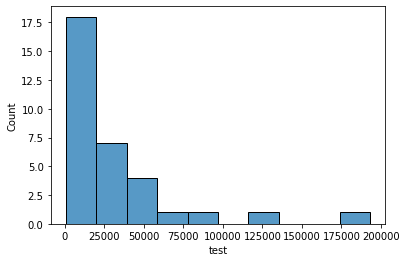

In [ ]:
absolute_error = abs(y_test - y_pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X_test
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y_test
TestingData['valor predito']=y_pred
TestingData.head()

,vltotal,totvolume,condvenda,valor real,valor predito
dtemissao,,,,,
2022-06-13,15327.830,1323,2,27504.458,9708.063477
2022-06-14,493.933,151,1,15327.830,19762.574219
2022-06-15,18396.396,1516,5,493.933,29852.460938
2022-06-16,261672.826,22405,56,18396.396,55411.789062
2022-06-17,97253.969,8492,37,261672.826,68473.710938


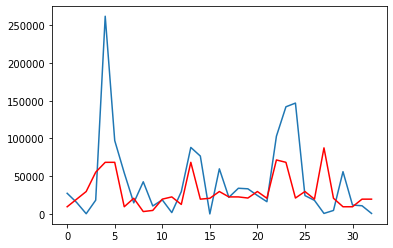

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y_test.values) 
plt.plot(y_pred, color='red')
plt.show()

In [ ]:
model_foward = pickle.dumps(xgb_r)

In [ ]:
xgb_foward = pickle.loads(model_foward)

[21:24:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#Testando novos dados 1106

X = df[['vltotal', 'totvolume', 'condvenda']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((155, 3), (52, 3), (155,), (52,))

In [ ]:
#Testando novos dados 1106

pred = xgb_foward.predict(X)

In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y, pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y, pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y, pred)):.2f}')
print(f'R: {metrics.r2_score(y, pred):.2f}')
MAPE = np.mean(100 * (np.abs(y, pred)/y))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y: {y.mean():.2f}')
print(f'median y: {y.median():.2f}')
print(f'mean pred: {pred.mean():.2f}')
print(f'median pred: {np.median(pred):.2f}')

MAE: 21517.40
MSE: 1892282147.27
RMSE: 43500.37
R: -0.08
MAPE: 100.00
Acurácia: -0.00
mean y: 24138.34
median y: 12029.01
mean pred: 24138.34
median pred: 12029.01


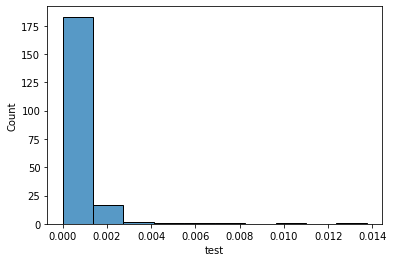

In [ ]:
absolute_error = abs(y - pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y
TestingData['valor predito']=pred
TestingData.head()

,vltotal,totvolume,condvenda,valor real,valor predito
dtemissao,,,,,
2021-09-27,5062.070,783,13,269.24,269.239990
2021-09-28,3049.300,312,1,5062.07,5062.069824
2021-09-29,75858.840,15209,17,3049.30,3049.300049
2021-09-30,69926.710,16149,18,75858.84,75858.843750
2021-10-01,14842.031,5938,1,69926.71,69926.710938


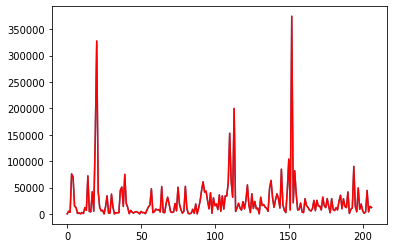

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y.values) 
plt.plot(pred, color='red')
plt.show()

###### **Testando outro vendedor**

In [ ]:
df_574 = dataframe[dataframe['codvendedor'] == '574']
df_574.head()

,numpedido,numcarga,numnota,condvenda,posicao,dtemissao,vltotal,vltabela,codcli,codvendedor,codfilial,codfilialnf,codplpag,codcob,origem,motorista,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,pedido_id,chave_nfe,perc_comissao,numpedidotv1,dtemissaonf,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho
1,8804585,227909.0,4589720.0,1,F,2021-09-27,2581.90,2581.90,28802,574,0,0,102,3,F,NaN,NaN,NaN,254.362,638,32eba715-6b04-45d2-9f9c-03f6ca3b3cad,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8804371,227909.0,4589721.0,1,F,2021-09-27,112.52,112.52,28802,574,0,0,102,3,F,NaN,NaN,NaN,8.960,28,f97931fe-e89f-4da6-9038-81a7ca47b650,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8804370,227905.0,4589673.0,1,F,2021-09-27,75.90,75.90,22580,574,0,0,102,3,F,GEOVANE MATEUS DE ABREU SILVA,NaN,NaN,9.330,10,0c6965a9-2f68-4b85-bcba-600a4a962036,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8804338,227905.0,4589671.0,1,F,2021-09-27,1787.90,1787.90,22580,574,0,0,102,3,F,GEOVANE MATEUS DE ABREU SILVA,NaN,NaN,157.281,424,1a7c8925-8146-4405-ba03-b5c6dc58d19e,NaN,NaN,NaN,2021-09-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,8809757,227978.0,4591338.0,1,ET,2021-09-28,47.78,47.78,21044,574,0,0,7,3,F,GEOVANE MATEUS DE ABREU SILVA,NaN,NaN,3.880,22,2f13a176-2b2a-4103-baa9-63fdd9ffa2a5,27210903636036000154550010045913381550414510,NaN,NaN,2021-09-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fig = px.line(df_574, x="dtemissao", y=["vltotal"])
fig.show()

In [ ]:
df_574.shape

(1614, 40)

In [ ]:
df = df_574.groupby(df_574['dtemissao']).sum()
df.shape

(199, 32)

In [ ]:
df

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho
dtemissao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-27 00:00:00,35217664,911628.0,18358785.0,4,4558.2200,4558.2200,102764,0,0,408,12,0.0,0.0,429.9330,1100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-28 00:00:00,52854391,1367886.0,27548447.0,6,5889.4160,5889.4171,84984,0,0,42,18,0.0,0.0,608.0730,1323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-29 00:00:00,17626863,456138.0,9186095.0,2,11501.1800,11501.1800,810,0,0,191,6,0.0,0.0,341.3180,1846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-30 00:00:00,211622429,5019788.0,101074392.0,24,166478.1810,166479.7033,382792,0,0,609,72,0.0,0.0,7901.1890,32980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-01 00:00:00,17639577,456552.0,9191649.0,2,3011.9860,3011.9859,28968,0,0,12,6,0.0,0.0,330.6500,656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-02 00:00:00,158760528,4108867.0,82725239.0,18,32243.8950,32243.8999,172887,0,0,126,54,0.0,0.0,2675.0950,9061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-04 00:00:00,70574522,1826694.0,36777161.0,8,8025.3670,8025.3666,154956,0,0,626,24,0.0,0.0,686.9370,2137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-05 00:00:00,44132998,685448.0,13800530.0,5,3262.3770,3262.3772,73774,0,0,35,15,0.0,0.0,304.8940,788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-06 00:00:00,97128124,1827861.0,36801408.0,11,18892.1460,18892.1506,184313,0,0,77,33,0.0,0.0,720.9570,3124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Criando janela de tempo 1 dia anterior

window = -1
history = [df['vltotal'].values[i] for i in range(window)]
test = [df['vltotal'].values[i] for i in range(window, len(df['vltotal'].values))]

In [ ]:
len(test)

200

In [ ]:
test.pop(199)

1224.75

In [ ]:
len(test)

199

In [ ]:
df['test'] = test
df.head()

,numpedido,numcarga,numnota,condvenda,vltotal,vltabela,codcli,codfilial,codfilialnf,codplpag,codcob,codfornecfrete,codfornecfreteredespacho,totpeso,totvolume,perc_comissao,numpedidotv1,tstamp,obs,obs_entrega,perc_lucratividade,numpedorigem,vlfrete,dtabertura,dtfechamento,codsegmento,codtabvenda,codplpagetico,codplpaggenerico,codmotorista,fretedespacho,freteredespacho,test
dtemissao,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-27,35217664,911628.0,18358785.0,4,4558.220,4558.2200,102764,0,0,408,12,0.0,0.0,429.933,1100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1224.750
2021-09-28,52854391,1367886.0,27548447.0,6,5889.416,5889.4171,84984,0,0,42,18,0.0,0.0,608.073,1323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4558.220
2021-09-29,17626863,456138.0,9186095.0,2,11501.180,11501.1800,810,0,0,191,6,0.0,0.0,341.318,1846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5889.416
2021-09-30,211622429,5019788.0,101074392.0,24,166478.181,166479.7033,382792,0,0,609,72,0.0,0.0,7901.189,32980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11501.180
2021-10-01,17639577,456552.0,9191649.0,2,3011.986,3011.9859,28968,0,0,12,6,0.0,0.0,330.650,656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166478.181


In [ ]:
X = df[['vltotal', 'totvolume', 'condvenda']]
y = df['test']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=False, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((149, 3), (50, 3), (149,), (50,))

In [ ]:
X.shape

(199, 3)

In [ ]:
#Testando novos dados 574

pred = xgb_foward.predict(X)

In [ ]:
print(f'MAE: {metrics.mean_absolute_error(y, pred):.2f}')
print(f'MSE: {metrics.mean_squared_error(y, pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y, pred)):.2f}')
print(f'R: {metrics.r2_score(y, pred):.2f}')
MAPE = np.mean(100 * (np.abs(y, pred)/y))
acc = 100 - MAPE
print(f'MAPE: {MAPE:.2f}')
print(f'Acurácia: {acc:.2f}')
print(f'mean y: {y.mean():.2f}')
print(f'median y: {y.median():.2f}')
print(f'mean pred: {pred.mean():.2f}')
print(f'median pred: {np.median(pred):.2f}')

MAE: 24050.97
MSE: 2834782996.44
RMSE: 53242.68
R: -0.12
MAPE: 100.00
Acurácia: -0.00
mean y: 25274.26
median y: 10802.64
mean pred: 25274.26
median pred: 10802.64


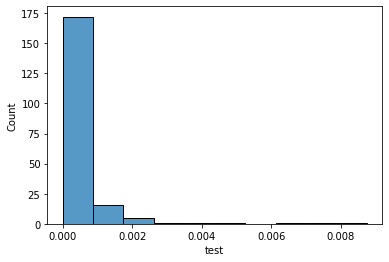

In [ ]:
absolute_error = abs(y - pred)

sns.histplot(absolute_error, bins=10)

In [ ]:
Test_Data=X
 
TestingData=pd.DataFrame(data=Test_Data)
TestingData['valor real']=y
TestingData['valor predito']=pred
TestingData.head()

,vltotal,totvolume,condvenda,valor real,valor predito
dtemissao,,,,,
2021-09-27,4558.220,1100,4,1224.750,1224.750000
2021-09-28,5889.416,1323,6,4558.220,4558.220215
2021-09-29,11501.180,1846,2,5889.416,5889.416016
2021-09-30,166478.181,32980,24,11501.180,11501.179688
2021-10-01,3011.986,656,2,166478.181,166478.187500


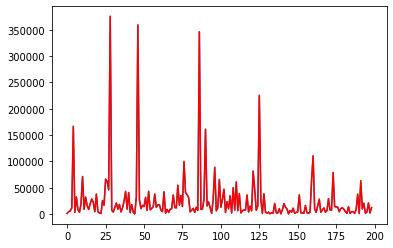

In [ ]:
# plot o valor real (test) e as predições 
plt.plot(y.values) 
plt.plot(pred, color='red')
plt.show()